# 1ère partie : anciennes cordes, $\mu_i$ mal choisis 

## Importation des données après deux désaccordages 

On va tout d'abord importer les données mesurées pour en déduire les $\rho_i$.

In [1]:
data = """79,05	102,40	115,40	126,10	217,50	240,70
82,4	101,5	114,1	123,1	215,8	239
81,90	104,80	113,20	121,50	214,20	237,50"""

In [2]:
data = data.replace(',', '.')

In [3]:
lines = data.split('\n')

In [4]:
values = [line.split('\t') for line in lines]

In [5]:
values

[['79.05', '102.40', '115.40', '126.10', '217.50', '240.70'],
 ['82.4', '101.5', '114.1', '123.1', '215.8', '239'],
 ['81.90', '104.80', '113.20', '121.50', '214.20', '237.50']]

In [6]:
import numpy as np

In [7]:
import pandas as pd

In [8]:
s = pd.DataFrame(values)

In [9]:
s

,0,1,2,3,4,5
0,79.05,102.40,115.40,126.10,217.50,240.70
1,82.4,101.5,114.1,123.1,215.8,239
2,81.90,104.80,113.20,121.50,214.20,237.50


In [10]:
s.values.astype(np.float)

array([[  79.05,  102.4 ,  115.4 ,  126.1 ,  217.5 ,  240.7 ],
       [  82.4 ,  101.5 ,  114.1 ,  123.1 ,  215.8 ,  239.  ],
       [  81.9 ,  104.8 ,  113.2 ,  121.5 ,  214.2 ,  237.5 ]])

In [11]:
df = pd.DataFrame(s.values.astype(np.float), columns=range(6))

In [12]:
df

,0,1,2,3,4,5
0,79.05,102.4,115.4,126.1,217.5,240.7
1,82.40,101.5,114.1,123.1,215.8,239.0
2,81.90,104.8,113.2,121.5,214.2,237.5


Il nous faut construire le vecteur des $\Delta T _ i$ à partir des mesures de fréquences. On construit d'abord le vecteur des $F_i$

In [13]:
df ** 2

,0,1,2,3,4,5
0,6248.9025,10485.76,13317.16,15901.21,47306.25,57936.49
1,6789.7600,10302.25,13018.81,15153.61,46569.64,57121.00
2,6707.6100,10983.04,12814.24,14762.25,45881.64,56406.25


In [14]:
(df ** 2).ix[0][0]


6248.9024999999992

**note importante** : j'utilise ici des $mu_i$ qui sont lus sur une pochette de cordes. Je n'ai aucune garantie que cela soient bien les vrais $mu_i$ nécessaires aux cordes qui sont sur ma guitare !

In [46]:
freqs = np.array([82.4, 110., 146.8, 196., 246.9, 329.6]) # frequencies of the guitar strings, from low E to high E, in Hz
calibration_tensions = np.array([9.59, 11.61, 11.22, 8.43, 8.09, 8.9]) * 9.81 # calibration tensions found on package (in kg) converted to N
mu = calibration_tensions / (4 * 0.648**2 * freqs**2) 
mu

array([ 0.00824942,  0.0056041 ,  0.00304088,  0.00128166,  0.00077511,
        0.00047849])

In [47]:
psi = 4 * 0.648**2 * mu

In [48]:
psi

array([ 0.01385585,  0.00941274,  0.00510752,  0.0021527 ,  0.00130189,
        0.00080368])

In [49]:
T = (df ** 2).values * psi
T

array([[  86.5838593 ,   98.69968579,   68.01761049,   34.23060795,
          61.58768385,   46.56255344],
       [  94.0779    ,   96.97235469,   66.49378303,   32.62124599,
          60.62869632,   45.90715825],
       [  92.93964188,  103.38045091,   65.44893844,   31.77876351,
          59.73299382,   45.33272606]])

**attention** les tensions sont bien en Newton, pas en kg comme dans la feuille Numbers.

## Construction de la matrice à inverser pour obtenir les raideurs du modèle 

On peut maintenant construire une première matrice de 5 lignes fois 6 colonnes.

In [50]:
T_end = T[1, :]
T_start = T[0, :]

mat = np.zeros((5, 6))
dT = T_end - T_start

dT

array([ 7.4940407 , -1.7273311 , -1.52382746, -1.60936196, -0.95898753,
       -0.65539519])

In [51]:
mat

array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

On s'attend à ce qu'il n'y ait qu'une valeur qui a augmenté, ici c'est la première.

In [52]:
np.nonzero(dT > 0)

(array([0]),)

In [53]:
tuned_string = np.nonzero(dT > 0)[0]
assert tuned_string.size == 1
tuned_string = tuned_string[0]

In [54]:
tuned_string

0

In [55]:

cnt = 0
for string in range(6):
        if string == tuned_string:
            continue
        else:
            for other_string in range(6):
                if other_string == tuned_string:
                    mat[cnt, other_string] = 0
                elif other_string == string:
                    mat[cnt, other_string] = dT[tuned_string] + dT[string]
                else:
                    mat[cnt, other_string] = dT[string]
            cnt += 1

In [56]:
mat[0]

array([ 0.       ,  5.7667096, -1.7273311, -1.7273311, -1.7273311,
       -1.7273311])

In [57]:
mat[1]

array([ 0.        , -1.52382746,  5.97021324, -1.52382746, -1.52382746,
       -1.52382746])

In [58]:
mat

array([[ 0.        ,  5.7667096 , -1.7273311 , -1.7273311 , -1.7273311 ,
        -1.7273311 ],
       [ 0.        , -1.52382746,  5.97021324, -1.52382746, -1.52382746,
        -1.52382746],
       [ 0.        , -1.60936196, -1.60936196,  5.88467874, -1.60936196,
        -1.60936196],
       [ 0.        , -0.95898753, -0.95898753, -0.95898753,  6.53505317,
        -0.95898753],
       [ 0.        , -0.65539519, -0.65539519, -0.65539519, -0.65539519,
         6.83864552]])

On peut écrire une fonction avec le code précédent :

In [134]:
def make_matrix(T_end, T_start):
    """ builds the matrix that describes the effect of the individual rho_i on the 
    overall tuning change
    M * [rho_i] = [dT]
    """
    mat = np.zeros((5, 6))
    dT = T_end - T_start
    upstrings = np.nonzero(dT > 0)[0]
    downstrings = np.nonzero(dT < 0)[0]

    if (upstrings.size == 5) and (downstrings.size == 1):
        tuned_string = downstrings[0]
    elif (upstrings.size == 1) and (downstrings.size == 5):
        tuned_string = upstrings[0]
    else:
        raise Exception('problem: no changed string was detected!')

    cnt = 0
    for string in range(6):
            if string == tuned_string:
                continue
            else:
                for other_string in range(6):
                    if other_string == tuned_string:
                        mat[cnt, other_string] = 0
                    elif other_string == string:
                        mat[cnt, other_string] = dT[tuned_string] + dT[string]
                    else:
                        mat[cnt, other_string] = dT[string]
                cnt += 1

    rhs = -dT[[_ for _ in range(6) if _ != tuned_string]] 
    return mat, rhs

In [135]:
make_matrix(T_end, T_start)

(array([[ 0.        ,  5.7667096 , -1.7273311 , -1.7273311 , -1.7273311 ,
         -1.7273311 ],
        [ 0.        , -1.52382746,  5.97021324, -1.52382746, -1.52382746,
         -1.52382746],
        [ 0.        , -1.60936196, -1.60936196,  5.88467874, -1.60936196,
         -1.60936196],
        [ 0.        , -0.95898753, -0.95898753, -0.95898753,  6.53505317,
         -0.95898753],
        [ 0.        , -0.65539519, -0.65539519, -0.65539519, -0.65539519,
          6.83864552]]),
 array([ 1.7273311 ,  1.52382746,  1.60936196,  0.95898753,  0.65539519]))

On vérifie que le RHS est correct :

In [136]:
dT

array([ 7.4940407 , -1.7273311 , -1.52382746, -1.60936196, -0.95898753,
       -0.65539519])

On peut maintenant construire les deux matrices :

In [137]:
mat1, rhs1 = make_matrix(T[1, :], T[0, :])
mat2, rhs2 = make_matrix(T[2, :], T[1, :])

In [138]:
mat2

array([[ 4.2994364 ,  0.        , -0.56407298, -0.56407298, -0.56407298,
        -0.56407298],
       [-0.2261193 ,  0.        ,  4.63739007, -0.2261193 , -0.2261193 ,
        -0.2261193 ],
       [-0.26421076,  0.        , -0.26421076,  4.59929862, -0.26421076,
        -0.26421076],
       [-0.11773104,  0.        , -0.11773104, -0.11773104,  4.74577834,
        -0.11773104],
       [-0.1058352 ,  0.        , -0.1058352 , -0.1058352 , -0.1058352 ,
         4.75767417]])

In [139]:
rhs2

array([ 0.56407298,  0.2261193 ,  0.26421076,  0.11773104,  0.1058352 ])

On peut les concaténer :

In [140]:
total_mat = np.vstack((mat1, mat2))
total_rhs = np.vstack((rhs1[:, np.newaxis], 
                       rhs2[:, np.newaxis]))

In [141]:
total_mat

array([[ 0.        , -4.4612643 ,  0.31964709,  0.31964709,  0.31964709,
         0.31964709],
       [ 0.        ,  0.2261193 , -4.55479209,  0.2261193 ,  0.2261193 ,
         0.2261193 ],
       [ 0.        ,  0.19820917,  0.19820917, -4.58270223,  0.19820917,
         0.19820917],
       [ 0.        ,  0.07850342,  0.07850342,  0.07850342, -4.70240798,
         0.07850342],
       [ 0.        ,  0.1058352 ,  0.1058352 ,  0.1058352 ,  0.1058352 ,
        -4.67507619],
       [ 4.2994364 ,  0.        , -0.56407298, -0.56407298, -0.56407298,
        -0.56407298],
       [-0.2261193 ,  0.        ,  4.63739007, -0.2261193 , -0.2261193 ,
        -0.2261193 ],
       [-0.26421076,  0.        , -0.26421076,  4.59929862, -0.26421076,
        -0.26421076],
       [-0.11773104,  0.        , -0.11773104, -0.11773104,  4.74577834,
        -0.11773104],
       [-0.1058352 ,  0.        , -0.1058352 , -0.1058352 , -0.1058352 ,
         4.75767417]])

In [142]:
total_rhs

array([[-0.31964709],
       [-0.2261193 ],
       [-0.19820917],
       [-0.07850342],
       [-0.1058352 ],
       [ 0.56407298],
       [ 0.2261193 ],
       [ 0.26421076],
       [ 0.11773104],
       [ 0.1058352 ]])

## Inversion du système ainsi construit 

On peut maintenant inverser le système :

In [143]:
total_mat.shape

(10, 6)

In [144]:
total_rhs.shape

(10, 1)

In [145]:
rho, err, rank, eigs = np.linalg.lstsq(total_mat, total_rhs)

In [146]:
err

array([ 0.00626796])

In [147]:
rho

array([[ 0.15357272],
       [ 0.08504085],
       [ 0.06070064],
       [ 0.06238074],
       [ 0.02644736],
       [ 0.02833926]])

In [148]:
err

array([ 0.00626796])

On a la solution ! 

**cependant** on note que les raideurs ne sont pas exactement dans l'ordre croissant !! Problème ou pas ?

## Vérification des prédictions du modèle 

On peut maintenant voir si ces coefs permettent de bien prédire la variation de tension observée. On peut tout simplement repartir des matrices mat1 et mat2 et vérifier que l'on tombe bien sur ce qu'on veut.

In [149]:
np.dot(mat1, rho)

array([[-0.32253471],
       [-0.2307556 ],
       [-0.24612583],
       [-0.10580322],
       [-0.10766249]])

In [150]:
rhs1

array([-0.31964709, -0.2261193 , -0.19820917, -0.07850342, -0.1058352 ])

Mouai...

In [151]:
np.dot(mat2, rho)

array([[ 0.55994563],
       [ 0.22027297],
       [ 0.2158191 ],
       [ 0.0896061 ],
       [ 0.10275017]])

In [152]:
rhs2

array([ 0.56407298,  0.2261193 ,  0.26421076,  0.11773104,  0.1058352 ])

Ceci est peut être dû à l'erreur à l'issue de la régression linéaire... on va quand même essayer d'implémenter la méthode d'inversion pour l'accordage.

**ou au mauvais $\mu_i$, qui ont été choisis... au hasard ?**

## Construction de la matrice nécessaire à la méthode d'accordage 

Il faut ici encore construire la matrice responsable de l'accordage.

In [153]:
tuning_mat = np.zeros((6, 6))

for other_string in range(6):
    for tuning_string in range(6):
        if tuning_string == other_string:
            tuning_mat[other_string, tuning_string] = 1.
        else:
            tuning_mat[other_string, tuning_string] = \
                    psi[tuning_string] / psi[other_string] * \
                        (- rho[other_string] / (1 + np.sum([rho[i] for i in range(6) if i != tuning_string])))

In [154]:
tuning_mat

array([[ 1.        , -0.0720598 , -0.03748629, -0.01683878, -0.00773359,
        -0.0051728 ],
       [-0.10778411,  1.        , -0.03322654, -0.01492531, -0.00685478,
        -0.00458499],
       [-0.1452357 , -0.08606456,  1.        , -0.02011139, -0.0092366 ,
        -0.00617813],
       [-0.33268321, -0.19714323, -0.10255604,  1.        , -0.02115776,
        -0.0141519 ],
       [-0.29916994, -0.17728376, -0.09222492, -0.04142729,  1.        ,
        -0.01272629],
       [-0.47992191, -0.28439474, -0.14794521, -0.06645676, -0.03052175,
         1.        ]])

In [155]:
np.dot(tuning_mat, np.array([1, 0, 0, 0, 0, 0]))

array([ 1.        , -0.10778411, -0.1452357 , -0.33268321, -0.29916994,
       -0.47992191])

On vérifie que ces termes sont les bons.

In [156]:
psi[0] / psi[1] * (- rho[1] / (1 + np.sum([rho[k] for k in range(6) if k != 0])))

array([-0.10778411])

On écrit la fonction pour calculer la matrice :

In [157]:
def compute_tuning_matrix(psi, rho):
    tuning_mat = np.zeros((6, 6))

    for other_string in range(6):
        for tuning_string in range(6):
            if tuning_string == other_string:
                tuning_mat[other_string, tuning_string] = 1.
            else:
                tuning_mat[other_string, tuning_string] = \
                        psi[tuning_string] / psi[other_string] * \
                            (- rho[other_string] / (1 + np.sum([rho[i] for i in range(6) if i != tuning_string])))
    return tuning_mat

In [158]:
compute_tuning_matrix(psi, rho)

array([[ 1.        , -0.0720598 , -0.03748629, -0.01683878, -0.00773359,
        -0.0051728 ],
       [-0.10778411,  1.        , -0.03322654, -0.01492531, -0.00685478,
        -0.00458499],
       [-0.1452357 , -0.08606456,  1.        , -0.02011139, -0.0092366 ,
        -0.00617813],
       [-0.33268321, -0.19714323, -0.10255604,  1.        , -0.02115776,
        -0.0141519 ],
       [-0.29916994, -0.17728376, -0.09222492, -0.04142729,  1.        ,
        -0.01272629],
       [-0.47992191, -0.28439474, -0.14794521, -0.06645676, -0.03052175,
         1.        ]])

On peut maintenant inverser la matrice en calculant l'accordage cible.

In [159]:
freqs

array([  82.4,  110. ,  146.8,  196. ,  246.9,  329.6])

Le $\Delta f$ à appliquer peut se calculer en faisant la différence à obtenir :

In [160]:
target_freqs = freqs.copy()

In [161]:
current_freqs = df.values[2, :]

L'écart que l'on cherche à obtenir est donc :

In [162]:
target_freqs - current_freqs

array([  0.5,   5.2,  33.6,  74.5,  32.7,  92.1])

On doit le mettre au carré :

In [163]:
target_dF = (target_freqs - current_freqs) ** 2

In [164]:
Delta_F = np.linalg.solve(tuning_mat, target_dF)
Delta_F

array([  231.11317523,   241.17522582,  1376.6233273 ,  5983.10944938,
        1674.54820262,  9314.30830504])

On doit prendre la racine de ce grand F pour trouver les fréquences à appliquer :

In [165]:
np.sqrt(Delta_F)

array([ 15.20240689,  15.52981731,  37.10287492,  77.35056205,
        40.9212439 ,  96.5106642 ])

In [166]:
np.sqrt(np.dot(tuning_mat, Delta_F))

array([  0.5,   5.2,  33.6,  74.5,  32.7,  92.1])

In [167]:
current_freqs

array([  81.9,  104.8,  113.2,  121.5,  214.2,  237.5])

In [168]:
current_freqs + np.sqrt(np.dot(tuning_mat, Delta_F))

array([  82.4,  110. ,  146.8,  196. ,  246.9,  329.6])

Cela devrait marcher. Voyons voir quels deltas de fréquence il faut imposer.

In [169]:
np.sqrt(Delta_F)

array([ 15.20240689,  15.52981731,  37.10287492,  77.35056205,
        40.9212439 ,  96.5106642 ])

## Essai pratique

Testons !

In [170]:
current_freqs + np.sqrt(Delta_F)

array([  97.10240689,  120.32981731,  150.30287492,  198.85056205,
        255.1212439 ,  334.0106642 ])

Conclusion : ça n'a pas marché et le pont n'a pas arrêté de monter. Je pense que cela vient d'autre chose : la tension du set de cordes n'était pas adaptée !!! 

Je change donc de set de cordes et je recommence.

# 2ème partie : nouvelles cordes, avec propriétés connues

J'ai mis des nouvelles cordes dont les propriétés sont les suivantes :

- mi aigu .009 5.94 kg
- si .011 4.99 kg
- sol .016 6.67 kg
- ré .026 8.34 kg
- la .036 8.84 kg
- mi grave .046 7.94 kg

On en déduit les $\mu_i$ :

In [171]:
freqs = np.array([82.4, 110., 146.8, 196., 246.9, 329.6]) # frequencies of the guitar strings, from low E to high E, in Hz
calibration_tensions = np.array([7.94, 8.84, 8.34, 6.67, 4.99, 5.94]) * 9.81 # calibration tensions found on package (in kg) converted to N
mu = calibration_tensions / (4 * 0.648**2 * freqs**2) 

In [172]:
mu

array([ 0.00683007,  0.00426703,  0.00226034,  0.00101408,  0.0004781 ,
        0.00031935])

J'ai remesuré la longueur des cordes et j'ai trouvé 65 cm. Je décide de garder la longueur standard de 0.648 m.

On en déduit les Psi_i :

In [173]:
psi = 4 * 0.648**2 * mu

In [174]:
psi

array([ 0.01147189,  0.00716698,  0.0037965 ,  0.00170327,  0.00080302,
        0.00053639])

On peut maintenant remesurer les différentes fréquences sur la guitare :

In [175]:
lines = """83,55	94,70	193,7	138,8	203	190
89,2	93,3	192,55	135,2	200,55	186,9
87,8	99,2	191,25	130,9	197,85	183,7""".replace(',', '.').split('\n')

In [176]:
history = np.array([line.split('\t') for line in lines], dtype=np.float)
history

array([[  83.55,   94.7 ,  193.7 ,  138.8 ,  203.  ,  190.  ],
       [  89.2 ,   93.3 ,  192.55,  135.2 ,  200.55,  186.9 ],
       [  87.8 ,   99.2 ,  191.25,  130.9 ,  197.85,  183.7 ]])

In [177]:
T = (history ** 2) * psi

In [178]:
mat1, rhs1 = make_matrix(T[1, :], T[0, :])
mat2, rhs2 = make_matrix(T[2, :], T[1, :])
total_mat = np.vstack((mat1, mat2))
total_rhs = np.vstack((rhs1[:, np.newaxis], 
                       rhs2[:, np.newaxis]))

In [179]:
rho, err, rank, eigs = np.linalg.lstsq(total_mat, total_rhs)

In [180]:
rho

array([[ 0.68364021],
       [ 0.38595602],
       [ 0.35713731],
       [ 0.36234102],
       [ 0.12312326],
       [ 0.07544867]])

In [181]:
err

array([ 15.1809818])

Cette fois-ci on constate que les rho_i sont dans l'ordre !

In [182]:
np.dot(mat1, rho)

array([[ 1.86173921],
       [ 1.79984672],
       [ 1.86626743],
       [ 0.34330066],
       [ 0.02756061]])

In [183]:
rhs1

array([ 1.88634787,  1.68635607,  1.68010244,  0.79394572,  0.62671325])

In [184]:
np.dot(mat2, rho)

array([[ 1.01157584],
       [-0.12690092],
       [-0.17216428],
       [-0.38132147],
       [-0.40471716]])

In [185]:
rhs2

array([ 2.84273508,  1.89422372,  1.94892905,  0.86379456,  0.63611618])

In [186]:
np.dot(total_mat, rho)

array([[ 1.86173921],
       [ 1.79984672],
       [ 1.86626743],
       [ 0.34330066],
       [ 0.02756061],
       [ 1.01157584],
       [-0.12690092],
       [-0.17216428],
       [-0.38132147],
       [-0.40471716]])

In [187]:
total_rhs

array([[ 1.88634787],
       [ 1.68635607],
       [ 1.68010244],
       [ 0.79394572],
       [ 0.62671325],
       [ 2.84273508],
       [ 1.89422372],
       [ 1.94892905],
       [ 0.86379456],
       [ 0.63611618]])

Bizarre la vérification...

In [188]:
tuning_mat = compute_tuning_matrix(psi, rho)

In [189]:
tuning_mat

array([[ 1.        , -0.16416206, -0.08600736, -0.03866298, -0.01670581,
        -0.01097622],
       [-0.2681349 ,  1.        , -0.07772219, -0.03493854, -0.01509652,
        -0.00991887],
       [-0.46838578, -0.25913886,  1.        , -0.06103165, -0.02637104,
        -0.01732656],
       [-1.05922014, -0.58602356, -0.30702796,  1.        , -0.05963618,
        -0.03918276],
       [-0.7634211 , -0.42236995, -0.22128698, -0.09947538,  1.        ,
        -0.02824053],
       [-0.70036106, -0.38748138, -0.20300825, -0.09125852, -0.03943171,
         1.        ]])

In [190]:
target_freqs = freqs.copy()

In [191]:
current_freqs = history[2, :]

In [192]:
target_freqs - current_freqs

array([  -5.4 ,   10.8 ,  -44.45,   65.1 ,   49.05,  145.9 ])

In [193]:
target_dF = (target_freqs - current_freqs) ** 2

In [194]:
Delta_F = np.linalg.solve(tuning_mat, target_dF)
Delta_F

array([  1366.2601893 ,   1472.7920829 ,   4161.43823636,   9189.9578263 ,
         6605.23136645,  24758.28871927])

In [195]:
np.sqrt(Delta_F)

array([  36.96295699,   38.37697334,   64.50921048,   95.86426772,
         81.2725745 ,  157.3476683 ])

In [196]:
for _ in np.sqrt(Delta_F):
    print("{:.2f}".format(_))

36.96
38.38
64.51
95.86
81.27
157.35


# 3ème partie : travail sur la méthode d'accordage 

Un des problèmes des parties précédentes provient du fait que l'accordage modifie au fur et à mesure les tensions des cordes et que lorsqu'on veut accorder la deuxième corde, on se pose la question de sa tension cible, qui a déjà changé par rapport aux conditions initiales.

Il y a deux possibilités :

- calculer la tension d'arrivée à l'issue de l'accordage de la première corde prédite par le modèle pour toutes les cordes et l'utiliser pour calculer la tension cible de la deuxième corde
- remesurer toutes les tensions des cordes et ajouter l'incrément de tension nécessaire à la deuxième corde selon ce qui a été calculé par le modèle

Idéalement, c'est à dire si le modèle est correct et que les paramètres ont été bien estimés, les deux méthodes se rejoignent.

Dans cette partie, nous allons confronter dans un premier temps les variations mesurées à l'issue d'un désaccordage avec les variations prédites. Dans un deuxième temps, nous conclurons sur la méthode à utiliser parmi les deux possibilités évoquées ci-dessus.

## Validation précise du modèle 

Plan de cette partie : 

- ré-inverser le modèle avec des nouvelles mesures indépendantes de la première série ci-dessus ; comparer les rho_i obtenus (on s'attend à trouver à peu près la même chose !)
- faire les étapes d'accordage une par une et comparer à chaque étape la fréquence mesurée sur la guitare pour chaque corde ainsi que celle prédite par la méthode

### Inversion du modèle 

Propriétés de la guitare connues à l'avance :

In [197]:
freqs = np.array([82.4, 110., 146.8, 196., 246.9, 329.6]) # frequencies of the guitar strings, from low E to high E, in Hz
calibration_tensions = np.array([7.94, 8.84, 8.34, 6.67, 4.99, 5.94]) * 9.81 # calibration tensions found on package (in kg) converted to N
mu = calibration_tensions / (4 * 0.648**2 * freqs**2) 
psi = 4 * 0.648**2 * mu

Afin de faire les prochaines mesures, on écrit la partie restante de l'application avec PyQt.

On désaccorde successivement le mi grave et le la pour obtenir les relevés suivants (à 0.1 Hz) :

In [198]:
history = np.array([[84.6,111.4,148.8,193.8,244.3,328.7],
[82.1,111.6,149.0,194.1,244.5,329.0],
[81.8,114.6,148.8,193.7,244.2,328.7]]) 
history

array([[  84.6,  111.4,  148.8,  193.8,  244.3,  328.7],
       [  82.1,  111.6,  149. ,  194.1,  244.5,  329. ],
       [  81.8,  114.6,  148.8,  193.7,  244.2,  328.7]])

In [199]:
T = (history ** 2) * psi
T

array([[ 82.10617348,  88.94187564,  84.05988844,  63.97204646,
         47.92634471,  57.95360474],
       [ 77.32526208,  89.26152273,  84.28600774,  64.17025563,
         48.00484813,  58.05943995],
       [ 76.7611891 ,  94.1250321 ,  84.05988844,  63.90604487,
         47.88711709,  57.95360474]])

On peut regarder la somme des tensions (et la remettre en kg pour avoir une petite idée) :

In [200]:
T.sum(axis=1) / 9.81

array([ 43.3190554 ,  42.92633397,  43.29183245])

On constate qu'on reste proche, mais qu'on ne conserve pas exactement les tensions. Je me demande ce que prédit le modèle à ce sujet.

In [258]:
mat1, rhs1 = make_matrix(T[1, :], T[0, :])
mat2, rhs2 = make_matrix(T[2, :], T[1, :])
total_mat = np.vstack((mat1, mat2))
total_rhs = np.vstack((rhs1[:, np.newaxis], 
                       rhs2[:, np.newaxis]))
rho, err, rank, eigs = np.linalg.lstsq(total_mat, total_rhs)

In [203]:
rho

array([[ 0.15357272],
       [ 0.08504085],
       [ 0.06070064],
       [ 0.06238074],
       [ 0.02644736],
       [ 0.02833926]])

In [204]:
err

array([ 0.00626796])

In [205]:
np.dot(total_mat, rho)

array([[-0.32253471],
       [-0.2307556 ],
       [-0.24612583],
       [-0.10580322],
       [-0.10766249],
       [ 0.55994563],
       [ 0.22027297],
       [ 0.2158191 ],
       [ 0.0896061 ],
       [ 0.10275017]])

In [206]:
total_rhs

array([[-0.31964709],
       [-0.2261193 ],
       [-0.19820917],
       [-0.07850342],
       [-0.1058352 ],
       [ 0.56407298],
       [ 0.2261193 ],
       [ 0.26421076],
       [ 0.11773104],
       [ 0.1058352 ]])

Cette fois-ci, la prédiction n'est pas si mauvaise...

### Prédictions successives du modèle

On peut maintenant calculer la matrice d'accord (dans le cadre du modèle linéaire).

In [207]:
tuning_mat = compute_tuning_matrix(psi, rho)

In [208]:
tuning_mat

array([[ 1.        , -0.0720598 , -0.03748629, -0.01683878, -0.00773359,
        -0.0051728 ],
       [-0.10778411,  1.        , -0.03322654, -0.01492531, -0.00685478,
        -0.00458499],
       [-0.1452357 , -0.08606456,  1.        , -0.02011139, -0.0092366 ,
        -0.00617813],
       [-0.33268321, -0.19714323, -0.10255604,  1.        , -0.02115776,
        -0.0141519 ],
       [-0.29916994, -0.17728376, -0.09222492, -0.04142729,  1.        ,
        -0.01272629],
       [-0.47992191, -0.28439474, -0.14794521, -0.06645676, -0.03052175,
         1.        ]])

Et maintenant, on peut prédire les changements à partir d'un état vers un autre :

In [ ]:
def predict_changes(initial_T, final_T, tuning_mat):
    """predicts changes in tuning (frequency) from a vector of tensions"""
    print("initial tunings: {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}".format(*[x for x in np.sqrt(initial_T))]))
    print("final tunings: {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}".format(*[x for x in np.sqrt(final_T))]))
    print("predicted tunings")

**attention au calcul des `target_dF`**, c'est :
$$
\delta F = f_{target}^2 - f_{current}^2
$$

In [218]:
target_freqs = freqs.copy()
current_freqs = history[2, :]
target_dF = target_freqs**2 - current_freqs**2
Delta_F = np.linalg.solve(tuning_mat, target_dF)
Delta_F

array([   20.88440591, -1033.69879388,  -651.71255386,   660.43531185,
        1119.90866086,   290.16859017])

In [219]:
np.sqrt(current_freqs**2 + np.dot(tuning_mat, Delta_F))

array([  82.4,  110. ,  146.8,  196. ,  246.9,  329.6])

In [216]:
target_freqs

array([  82.4,  110. ,  146.8,  196. ,  246.9,  329.6])

On peut maintenant écrire la séquence attendue :

In [227]:
print("initial: {:.1f}, {:.1f}, {:.1f}, {:.1f}, {:.1f}, {:.1f}".format(*[x for x in current_freqs]))
for step in range(6):
    new_F = np.sqrt(current_freqs**2 + np.dot(tuning_mat, Delta_F * (np.arange(6) <= step)))
    print(" step {}: {:.1f}, {:.1f}, {:.1f}, {:.1f}, {:.1f}, {:.1f}".format(step, *[x for x in new_F]))
    

initial: 81.8, 114.6, 148.8, 193.7, 244.2, 328.7
 step 0: 81.9, 114.6, 148.8, 193.7, 244.2, 328.7
 step 1: 82.4, 110.0, 149.1, 194.2, 244.6, 329.1
 step 2: 82.5, 110.1, 146.9, 194.4, 244.7, 329.3
 step 3: 82.5, 110.0, 146.8, 196.1, 244.6, 329.2
 step 4: 82.4, 110.0, 146.8, 196.0, 246.9, 329.2
 step 5: 82.4, 110.0, 146.8, 196.0, 246.9, 329.6


On peut écrire une fonction qui facilite le calcul :

In [228]:
def tuning_step(tuning_mat, initial_freqs, Delta_F, step_number):
    """predicts observed tuning as a function of tuning step
    convention: step 0 means nothing has changed"""
    step = step_number - 1
    if step == -1:
        return initial_freqs
    return np.sqrt(initial_freqs**2 + np.dot(tuning_mat, Delta_F * (np.arange(6) <= step)))

In [237]:
print_strings = lambda v: print("{:.1f}, {:.1f}, {:.1f}, {:.1f}, {:.1f}, {:.1f}".format(*v))

### Etape 0 : le programme 

In [233]:
%matplotlib inline
import matplotlib.pyplot as plt

In [229]:
initial_freqs = current_freqs.copy()

Les fréquences cibles des cordes sont :

In [246]:
for target, string in zip([tuning_step(tuning_mat, initial_freqs, Delta_F, i)[i-1] for i in range(1, 7)],
                          ["low E", "A", "D", "G", "B", "high E"]):
    print("string: {}, target frequency: {:.1f}".format(string, target))

string: low E, target frequency: 81.9
string: A, target frequency: 110.0
string: D, target frequency: 146.9
string: G, target frequency: 196.1
string: B, target frequency: 246.9
string: high E, target frequency: 329.6


### Etape 1 : mi grave

82.0, 114.5, 148.5, 193.5, 244.0, 328.7
81.9, 114.6, 148.8, 193.7, 244.2, 328.7


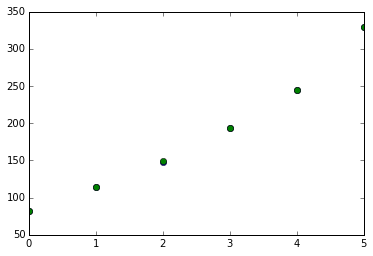

In [240]:
measured_freqs = [82.0,114.5,148.5,193.5,244.0,328.7]
expected_freqs = tuning_step(tuning_mat, initial_freqs, Delta_F, 1)
print_strings(measured_freqs)
print_strings(expected_freqs)
plt.plot(measured_freqs, 'o')
plt.plot(expected_freqs, 'o')

### La 

82.3, 110.0, 148.8, 194.1, 244.5, 329.2
82.4, 110.0, 149.1, 194.2, 244.6, 329.1


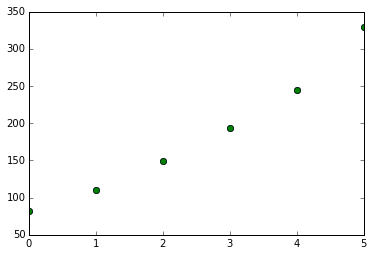

In [247]:
measured_freqs = [82.3,110.0,148.8,194.1,244.5,329.2]
expected_freqs = tuning_step(tuning_mat, initial_freqs, Delta_F, 2)
print_strings(measured_freqs)
print_strings(expected_freqs)
plt.plot(measured_freqs, 'o')
plt.plot(expected_freqs, 'o')

### Ré 

82.4, 110.2, 146.9, 194.4, 244.7, 329.5
82.5, 110.1, 146.9, 194.4, 244.7, 329.3


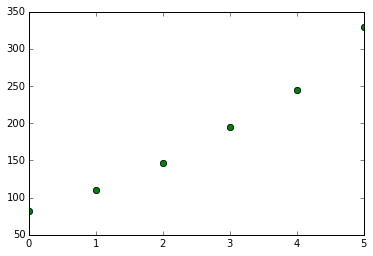

In [248]:
measured_freqs = [82.4,110.2,146.9,194.4,244.7,329.5]
expected_freqs = tuning_step(tuning_mat, initial_freqs, Delta_F, 3)
print_strings(measured_freqs)
print_strings(expected_freqs)
plt.plot(measured_freqs, 'o')
plt.plot(expected_freqs, 'o')

### Sol

82.4, 110.2, 147.0, 196.1, 244.6, 329.2
82.5, 110.0, 146.8, 196.1, 244.6, 329.2


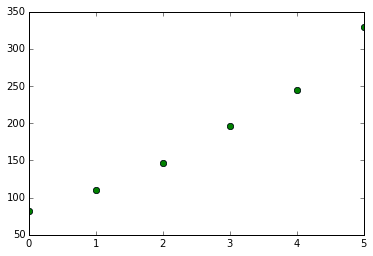

In [250]:
measured_freqs = [82.4,110.2,147.0,196.1,244.6,329.2]
expected_freqs = tuning_step(tuning_mat, initial_freqs, Delta_F, 4)
print_strings(measured_freqs)
print_strings(expected_freqs)
plt.plot(measured_freqs, 'o')
plt.plot(expected_freqs, 'o')

### Si 

82.4, 110.2, 146.9, 196.3, 246.8, 329.2
82.4, 110.0, 146.8, 196.0, 246.9, 329.2


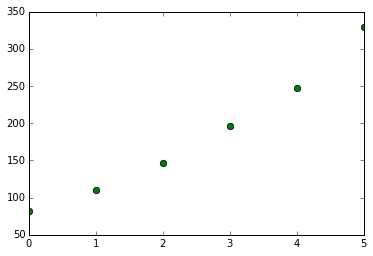

In [251]:
measured_freqs = [82.4,110.2,146.9,196.3,246.8,329.2]
expected_freqs = tuning_step(tuning_mat, initial_freqs, Delta_F, 5)
print_strings(measured_freqs)
print_strings(expected_freqs)
plt.plot(measured_freqs, 'o')
plt.plot(expected_freqs, 'o')

### Mi aigu 

82.4, 110.1, 146.9, 196.3, 246.7, 329.6
82.4, 110.0, 146.8, 196.0, 246.9, 329.6


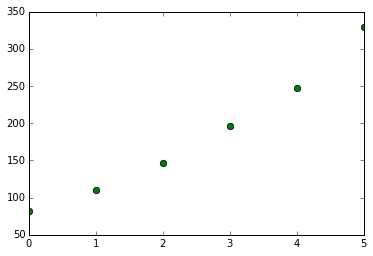

In [253]:
measured_freqs = [82.4,110.1,146.9,196.3,246.7,329.6]
expected_freqs = tuning_step(tuning_mat, initial_freqs, Delta_F, 6)
print_strings(measured_freqs)
print_strings(expected_freqs)
plt.plot(measured_freqs, 'o')
plt.plot(expected_freqs, 'o')

J'ai envie de penser que cela suffit.

à faire demain :

- refaire une inversion
- refaire un accordage en quantifiant l'erreur en demi-tons par rapport à la note cible

# 20150811 

Effet du serrage des boulons en tête de guitare sur l'accordage :

- avant : 83.3,112.8,150.0,201.3,250.2,334.3
- après : 83.1,112.9,149.7,201.3,250.4,334.5

Conclusion : petit effet, on va négliger ça.

J'utilise le protocole d'accordage suivant (attention différent de celui de l'étape précédente où j'avais descendu le mi et monté le la) :

- je monte le mi grave
- je descend le la

Au préalable, je met toutes les vis dans leurs positions neutres sur le vibrato pour le fine tuning.

## Inversion 

In [254]:
freqs = np.array([82.4, 110., 146.8, 196., 246.9, 329.6]) # frequencies of the guitar strings, from low E to high E, in Hz
calibration_tensions = np.array([7.94, 8.84, 8.34, 6.67, 4.99, 5.94]) * 9.81 # calibration tensions found on package (in kg) converted to N
mu = calibration_tensions / (4 * 0.648**2 * freqs**2) 
psi = 4 * 0.648**2 * mu

In [255]:
history = np.array([[83.7,112.7,151.3,204.2,251.2,333.4],
                    [84.9,112.3,150.9,203.3,250.5,332.8],
                    [85.0,109.4,151.1,203.9,250.9,333.0]]) 
history

array([[  83.7,  112.7,  151.3,  204.2,  251.2,  333.4],
       [  84.9,  112.3,  150.9,  203.3,  250.5,  332.8],
       [  85. ,  109.4,  151.1,  203.9,  250.9,  333. ]])

In [256]:
T = (history ** 2) * psi

In [257]:
T.sum(axis=1) / 9.81

array([ 44.81380154,  44.82358266,  44.46323347])

In [259]:
mat1, rhs1 = make_matrix(T[1, :], T[0, :])
mat2, rhs2 = make_matrix(T[2, :], T[1, :])
total_mat = np.vstack((mat1, mat2))
total_rhs = np.vstack((rhs1[:, np.newaxis], 
                       rhs2[:, np.newaxis]))
rho, err, rank, eigs = np.linalg.lstsq(total_mat, total_rhs)

In [260]:
rho

array([[ 0.05618364],
       [ 0.20798309],
       [ 0.07109296],
       [ 0.13408866],
       [ 0.03335705],
       [ 0.00464332]])

In [261]:
err

array([ 1.02619521])

In [262]:
np.dot(total_mat, rho)

array([[  1.91713366e-01],
       [ -4.20425924e-02],
       [  2.93882053e-02],
       [ -4.98130452e-02],
       [ -8.59553762e-02],
       [ -2.00537949e-01],
       [ -2.58939590e-01],
       [ -4.93283586e-01],
       [ -1.05490662e-01],
       [ -1.33810752e-05]])

In [263]:
total_rhs

array([[ 0.64502777],
       [ 0.45892044],
       [ 0.62467312],
       [ 0.28201325],
       [ 0.214406  ],
       [-0.19490746],
       [-0.22930836],
       [-0.41614216],
       [-0.16105407],
       [-0.07142575]])

On peut remarquer que l'inversion ne donne pas des valeurs satisfaisantes car les signes du produit matrice vecteur ne respectent pas celles observées (que des moins ou que des plus). On peut imaginer faire plus de mesures pour voir ce que ça donne : je vais rajouter un désaccordage.

In [264]:
history = np.vstack((history,
                     np.array([82.3,109.5,151.3,204.0,251.1,333.3])))

In [265]:
history

array([[  83.7,  112.7,  151.3,  204.2,  251.2,  333.4],
       [  84.9,  112.3,  150.9,  203.3,  250.5,  332.8],
       [  85. ,  109.4,  151.1,  203.9,  250.9,  333. ],
       [  82.3,  109.5,  151.3,  204. ,  251.1,  333.3]])

In [268]:
T = (history ** 2) * psi

In [269]:
mat3, rhs3 = make_matrix(T[3, :], T[2, :])

In [270]:
total_mat = np.vstack((mat1, mat2, mat3))
total_rhs = np.vstack((rhs1[:, np.newaxis], 
                       rhs2[:, np.newaxis],
                       rhs3[:, np.newaxis]))
rho, err, rank, eigs = np.linalg.lstsq(total_mat, total_rhs)

In [271]:
rho

array([[ 0.04387418],
       [ 0.05047254],
       [ 0.05012372],
       [ 0.05922661],
       [ 0.01700319],
       [ 0.00748409]])

In [272]:
err

array([ 1.2347814])

In [273]:
np.dot(total_mat, rho)

array([[-0.00173873],
       [ 0.03175313],
       [ 0.02233097],
       [-0.01251362],
       [-0.02214667],
       [-0.16752885],
       [-0.19021247],
       [-0.19895477],
       [-0.04972716],
       [-0.02179249],
       [-0.23263164],
       [-0.21741973],
       [-0.29410528],
       [-0.07325027],
       [-0.01902078]])

In [274]:
total_rhs

array([[ 0.64502777],
       [ 0.45892044],
       [ 0.62467312],
       [ 0.28201325],
       [ 0.214406  ],
       [-0.19490746],
       [-0.22930836],
       [-0.41614216],
       [-0.16105407],
       [-0.07142575],
       [-0.15688509],
       [-0.22961208],
       [-0.06947626],
       [-0.0806234 ],
       [-0.10721909]])

On laisse tomber et on recommence la procédure de calibration, avec un précision supérieure :

In [275]:
history = np.array([[81.08,110.53,151.17,203.89,251.09,333.24],
                    [82.9,110.47,151.04,203.57,250.96,333.19],
                    [82.87,112.37,150.96,203.42,250.69,333.02]]) 
history

array([[  81.08,  110.53,  151.17,  203.89,  251.09,  333.24],
       [  82.9 ,  110.47,  151.04,  203.57,  250.96,  333.19],
       [  82.87,  112.37,  150.96,  203.42,  250.69,  333.02]])

In [276]:
T = (history ** 2) * psi

In [277]:
T.sum(axis=1) / 9.81

array([ 43.90750437,  44.2018119 ,  44.46809096])

In [278]:
mat1, rhs1 = make_matrix(T[1, :], T[0, :])
mat2, rhs2 = make_matrix(T[2, :], T[1, :])
total_mat = np.vstack((mat1, mat2))
total_rhs = np.vstack((rhs1[:, np.newaxis], 
                       rhs2[:, np.newaxis]))
rho, err, rank, eigs = np.linalg.lstsq(total_mat, total_rhs)

In [279]:
rho

array([[ 0.02215722],
       [ 0.03137893],
       [ 0.04359332],
       [ 0.05969175],
       [ 0.02787037],
       [ 0.01310833]])

In [280]:
err

array([ 0.01260648])

In [281]:
np.dot(total_mat, rho)

array([[ 0.09074039],
       [ 0.12305319],
       [ 0.16535995],
       [ 0.08621463],
       [ 0.04173985],
       [ 0.05774091],
       [ 0.11701787],
       [ 0.16382797],
       [ 0.06647086],
       [ 0.02966687]])

In [282]:
total_rhs

array([[ 0.09503409],
       [ 0.14915408],
       [ 0.2220842 ],
       [ 0.05241043],
       [ 0.01787333],
       [ 0.05705087],
       [ 0.09172334],
       [ 0.10398189],
       [ 0.1087657 ],
       [ 0.06074928]])

Tout est de même signe, c'est pas si mal. Et l'erreur est faible.

## Accordage 

In [286]:
tuning_mat = compute_tuning_matrix(psi, rho)

In [287]:
target_freqs = freqs.copy()
current_freqs = history[2, :]
target_dF = target_freqs**2 - current_freqs**2
Delta_F = np.linalg.solve(tuning_mat, target_dF)
Delta_F

array([ -108.74905696,  -586.32552748, -1383.34495944, -3387.03863802,
       -2423.31722246, -2655.85641727])

In [288]:
initial_freqs = current_freqs.copy()
initial_freqs

array([  82.87,  112.37,  150.96,  203.42,  250.69,  333.02])

In [294]:
for target, string in zip([tuning_step(tuning_mat, initial_freqs, Delta_F, i)[i-1] for i in range(1, 7)],
                          ["low E", "A", "D", "G", "B", "high E"]):
    print("string: {}, target frequency: {:.1f}".format(string, target))

string: low E, target frequency: 82.2
string: A, target frequency: 109.8
string: D, target frequency: 146.5
string: G, target frequency: 195.7
string: B, target frequency: 246.8
string: high E, target frequency: 329.6


Mi grave :

In [290]:
measured_freqs = [82.18,112.37,150.94,203.43,250.67,333.08]
expected_freqs = tuning_step(tuning_mat, initial_freqs, Delta_F, 1)
print_strings(measured_freqs)
print_strings(expected_freqs)

82.2, 112.4, 150.9, 203.4, 250.7, 333.1
82.2, 112.4, 151.0, 203.5, 250.8, 333.1


La :

In [291]:
measured_freqs = [82.44,109.75,150.91,203.92,251.13,333.26]
expected_freqs = tuning_step(tuning_mat, initial_freqs, Delta_F, 2)
print_strings(measured_freqs)
print_strings(expected_freqs)

82.4, 109.8, 150.9, 203.9, 251.1, 333.3
82.3, 109.8, 151.1, 203.8, 251.0, 333.2


Re :

In [292]:
measured_freqs = [82.66,110.12,146.65,204.46,251.57,333.51]
expected_freqs = tuning_step(tuning_mat, initial_freqs, Delta_F, 3)
print_strings(measured_freqs)
print_strings(expected_freqs)

82.7, 110.1, 146.7, 204.5, 251.6, 333.5
82.3, 109.8, 146.5, 204.2, 251.3, 333.4


Sol :

In [296]:
measured_freqs = [82.86,110.39,146.96,195.81,251.94,333.99]
expected_freqs = tuning_step(tuning_mat, initial_freqs, Delta_F, 4)
print_strings(measured_freqs)
print_strings(expected_freqs)

82.9, 110.4, 147.0, 195.8, 251.9, 334.0
82.4, 109.9, 146.7, 195.7, 251.7, 333.5


Si :

In [298]:
measured_freqs = [82.97,110.52,147.1,196.29,246.53,334.24]
expected_freqs = tuning_step(tuning_mat, initial_freqs, Delta_F, 5)
print_strings(measured_freqs)
print_strings(expected_freqs)

83.0, 110.5, 147.1, 196.3, 246.5, 334.2
82.4, 110.0, 146.8, 195.9, 246.8, 333.6


Mi :

In [300]:
measured_freqs = [83.2,110.75,147.17,196.55,246.67,329.84]
expected_freqs = tuning_step(tuning_mat, initial_freqs, Delta_F, 6)
print_strings(measured_freqs)
print_strings(expected_freqs)

83.2, 110.8, 147.2, 196.6, 246.7, 329.8
82.4, 110.0, 146.8, 196.0, 246.9, 329.6


Même si l'accord n'est pas parfait, on a atteint le but. Je reserre les boulons du manche et remesure :

- 83.62,111.07,148.34,197.48,247.28,329.57

On peut maintenant utiliser les vis de tuning fines pour arriver à un accordage parfait.

**to do pour la suite**

- écrire des fonctions pour donner la suite d'accordage
- comprendre pourquoi parfois la procédure de calibration ne marche pas 
- réfléchir à comment coder un logiciel pour faire l'accordage itératif